## Image segmentation with fastai

In [50]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/img_wmasks'
path_lbl = path+'/data/h5/masks2/'
path_infer = img_path+'/s2-hr/'
path_infer_400 = img_path+'/s2-hr-400/'
path_infer_mask = img_path+'/s2-hr-mask/'
il = ImageList.from_folder(path_infer_400)
gt_il = ImageList.from_folder(path_infer_400)

## Data

In [5]:
fnames = get_image_files(path_infer_400)
img_f = fnames[0]
lbl_names = get_image_files(path_lbl)
get_y_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'
mask = open_mask(get_y_fn(img_f))

src_size = np.array(mask.shape[1:])
codes = array(['Background' , 'Building'])
size = src_size//2


free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

src = (SegmentationItemList.from_folder(path_infer_400)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

using bs=16, have 16278MB of GPU RAM free


In [6]:
data.valid_dl = data.valid_dl.new(shuffle=True)

In [7]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid
wd=1e-2

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

## Datasets

In [6]:
lr=3e-3

In [7]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


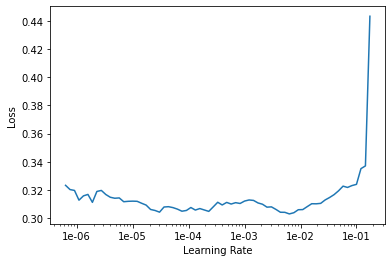

In [11]:
lr_find(learn)
learn.recorder.plot()

In [9]:
lr=1e-3

In [10]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.348667,0.344063,0.098483,00:30
1,0.321779,0.321441,0.083387,00:26
2,0.319266,0.318638,0.113607,00:26
3,0.316201,0.310070,0.075912,00:26
4,0.319531,0.316168,0.036262,00:26
5,0.620635,0.355659,0.040422,00:26
6,0.376335,0.364535,0.005478,00:26
7,0.331183,0.335384,0.059795,00:26
8,0.324994,0.334639,0.066710,00:26
9,0.318136,0.323232,0.050104,00:26


In [12]:
learn.save('stage-1')

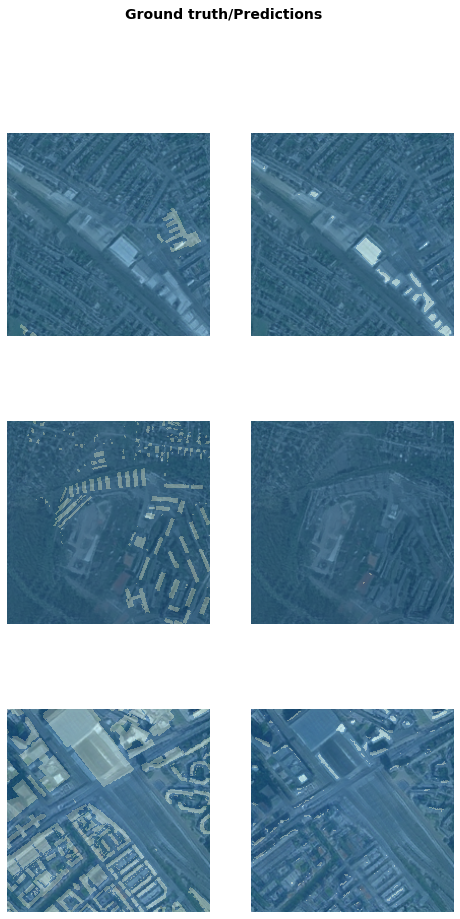

In [13]:
learn.show_results(rows=3, figsize=(8,15))

In [14]:
learn.unfreeze()

In [16]:
lrs = slice(lr/400,lr/4)

In [17]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.316250,0.320307,0.068943,00:28
1,0.308376,0.320458,0.066404,00:28
2,0.312290,0.319850,0.062580,00:28
3,0.314719,0.320456,0.068165,00:28
4,0.313477,0.320214,0.055572,00:28
5,0.311265,0.321177,0.061157,00:28
6,0.305862,0.319606,0.076161,00:28
7,0.313937,0.324750,0.083200,00:28
8,0.310272,0.324273,0.065237,00:28
9,0.307609,0.319446,0.054650,00:28


## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [78]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=6
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=6, have 4810MB of GPU RAM free


In [79]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [80]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [21]:
learn.load('stage-2');

#### lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.305789,0.306079,0.138799,01:41
1,0.294002,0.298142,0.180761,01:37
2,0.291189,0.292378,0.187018,01:37
3,0.287343,0.292436,0.140837,01:37
4,0.287509,0.289124,0.232736,01:37
5,0.283233,0.287545,0.182581,01:37
6,0.288867,0.291685,0.235242,01:37
7,0.287008,0.298700,0.132845,01:37
8,0.284490,0.283119,0.173868,01:37
9,0.277076,0.281408,0.239664,01:37


In [26]:
learn.save('stage-1-big')

In [27]:
learn.load('stage-1-big');

In [85]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [88]:
lr = 1e3

In [89]:
lrs = slice(1e-6,lr/10)

In [90]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,nan,nan,0.000000,01:56
1,nan,nan,0.000000,01:55
2,nan,nan,0.000000,01:55
3,nan,nan,0.000000,01:55
4,nan,nan,0.000000,01:55
5,nan,nan,0.000000,01:55
6,nan,nan,0.000000,01:55
7,nan,nan,0.000000,01:55
8,nan,nan,0.000000,01:55
9,nan,nan,0.000000,01:55


In [31]:
learn.save('stage-2-big')

In [81]:
learn.load('stage-2-big');

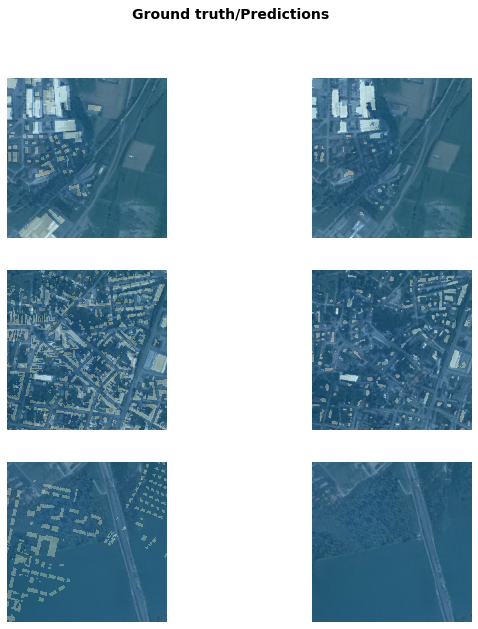

In [82]:
learn.show_results(rows=3, figsize=(10,10))

In [34]:
learn.export()

In [74]:
learn = load_learner(path_infer_400)

## Inference

In [75]:
path_infer = img_path+'/s2-hr/'
path_infer_400 = img_path+'/s2-hr-400/'
path_infer_mask = img_path+'/s2-hr-mask-v2/'


In [76]:
#runonce

#upsample naively the results of the superrez network
onlypngs = []
onlypngs = sorted([f for f in os.listdir(path_infer) if os.path.isfile(os.path.join(path_infer, f))])


for line in onlypngs:
    gt = Image.open(path_infer+line)
    fn = line.replace("_result", "")
    gt = gt.resize((400, 400))
    gt.save(path_infer_400+fn)

In [ ]:
#create lists of the images
il = ImageList.from_folder(path_infer_400) 

In [68]:
#functions to get path from a filename stem(loc_id) 
get_y_fn = lambda x: path_infer_mask+f'/{x.stem}.tif'
get_gtmask_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'
get_gtimg_fn = lambda x: path_img+f'/{x.stem}.png'

In [69]:
for idx, im in enumerate(il):
    msk = learn.predict(im)[0]
    msk.save(get_y_fn(il.items[idx]))

OSError: image file is truncated

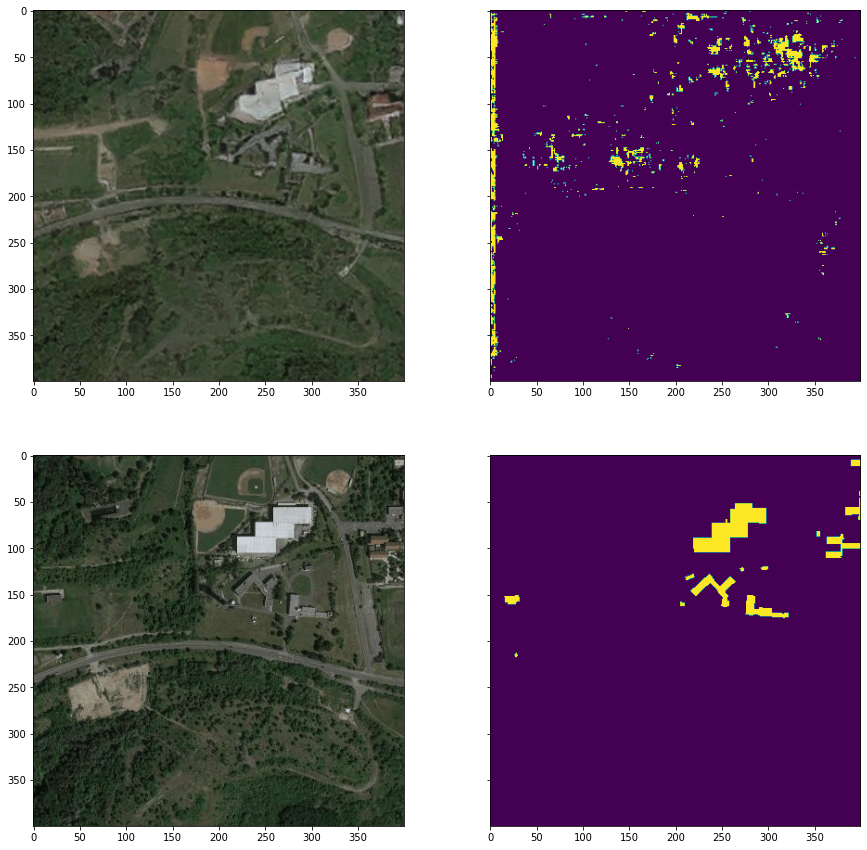

In [77]:
idx = 25

img = transforms.ToPILImage()(il[idx].data)
gt_img = Image.open(get_gtimg_fn(il.items[idx]))
oldmask = Image.open(get_gtmask_fn(il.items[idx]))
mask = Image.open(get_y_fn(il.items[idx]))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(15,15))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(gt_img)
ax4.imshow(oldmask)

In [56]:
il.items[idx]

PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/s2-hr-400/9362800_5524000.png')